# 3D

In [13]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import scipy.signal
from scipy.special import erfc
import scipy as sp
from meep.materials import Si,SiO2 ## Problem!
import meep as mp
plt.rcParams["figure.figsize"] = (12,6)



SiO2 = mp.Medium(epsilon=2.25)
Si = mp.Medium(epsilon=12)

resolution = 15  # Original: 45
three_d = True

gdsII_file = 'demo.gds'
CELL_LAYER = 1
ESTRUTURA_LAYER = 2
SOURCE_LAYER = 4
PORT1_LAYER = 3
PORT2_LAYER = 5
PORT3_LAYER = 6
PORT4_LAYER = 7

default_d = 0.3

t_oxide = 2.0
t_Si = 0.22


dpml = 0.5
cell_thickness = dpml+t_oxide+dpml

SiO2 = mp.Medium(epsilon=2.25)
Si = mp.Medium(epsilon=12)

λinicial = 1520e-9 *1e6
λfinal = 1575e-9 *1e6
Npontos = 25

finicial = 1/λfinal
ffinal = 1/λinicial

fArray = 1/np.linspace(λinicial,λfinal,Npontos)


fcen = (ffinal + finicial)/2  # pulse center frequency
df = ffinal - finicial   # pulse width (in frequency)

In [14]:
fArray

array([0.65789474, 0.65690434, 0.65591692, 0.65493246, 0.65395095,
       0.65297238, 0.65199674, 0.65102401, 0.65005417, 0.64908722,
       0.64812314, 0.64716193, 0.64620355, 0.64524802, 0.6442953 ,
       0.6433454 , 0.64239829, 0.64145396, 0.64051241, 0.63957362,
       0.63863757, 0.63770426, 0.63677368, 0.63584581, 0.63492063])

Se o bash !mpirun não rodar por algum motivo, tente não executar esta célula abaixo, apesar de que ela ainda será considerada no arquivo .py

In [15]:
from mpi4py.MPI import COMM_WORLD

comm = COMM_WORLD
rank = comm.Get_rank()

Proccess call: Use a variável "rank" para instruir o processo

In [17]:
####
cell_zmax = 0.5*cell_thickness if three_d else 0
cell_zmin = -0.5*cell_thickness if three_d else 0
si_zmax = 0.5*t_Si if three_d else 10
si_zmin = -0.5*t_Si if three_d else -10

estrutura = mp.get_GDSII_prisms(Si, gdsII_file, ESTRUTURA_LAYER, si_zmin, si_zmax)

# cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
# p1 = mp.GDSII_vol(gdsII_file, PORT1_LAYER, si_zmin, si_zmax)
# p2 = mp.GDSII_vol(gdsII_file, PORT2_LAYER, si_zmin, si_zmax)
# p3 = mp.GDSII_vol(gdsII_file, PORT3_LAYER, si_zmin, si_zmax)
# p4 = mp.GDSII_vol(gdsII_file, PORT4_LAYER, si_zmin, si_zmax)
# src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
p1 = mp.GDSII_vol(gdsII_file, PORT1_LAYER, cell_zmin, cell_zmax)
p2 = mp.GDSII_vol(gdsII_file, PORT2_LAYER, cell_zmin, cell_zmax)
p3 = mp.GDSII_vol(gdsII_file, PORT3_LAYER, cell_zmin, cell_zmax)
p4 = mp.GDSII_vol(gdsII_file, PORT4_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, cell_zmin, cell_zmax)
sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                                  volume=src_vol,
                                  eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y+mp.ODD_Z)]

# sources = [mp.EigenModeSource(src=mp.ContinuousSource(fcen,fwidth=df),
#                               volume=src_vol,
#                               eig_parity=mp.EVEN_Y+mp.ODD_Z)]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell.size,
                    boundary_layers=[mp.PML(dpml)],
                    sources=sources,
                    geometry=estrutura,
                    default_material=SiO2)


## Aplicação MPI A

5 cores onde cada um considera todos monitores, com a mesma source, porém cada um com 5 pontos (totalizando os 25) 

É necessário mudar a variável *cores*, mais abaixo no código, para 5

OBS: Veja que a célula abaixo possui a tag "active-ipynb". Portanto ela está DESATIVADA para o uso do mpi. Para ATIVAR, retire a tag

In [18]:
# mode1 = sim.add_mode_monitor(fcen, df, Npontos, mp.ModeRegion(volume=p1))
# mode2 = sim.add_mode_monitor(fcen, df, Npontos, mp.ModeRegion(volume=p2))
# mode3 = sim.add_mode_monitor(fcen, df, Npontos, mp.ModeRegion(volume=p3))
# mode4 = sim.add_mode_monitor(fcen, df, Npontos, mp.ModeRegion(volume=p4))

fcenRank = (fArray[rank] + fArray[rank+5])/2
dfRank = fArray[rank] - fArray[rank+5]

print(f'Hi, im proccess {rank} and im starting the simulation with fcen = {fcenRank} and df = {dfRank}.')

# MPI TEST: Render 5 monitor points for each proccess -------------------------------------------------------------
mode1 = sim.add_mode_monitor(fcenRank, dfRank, Npontos, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcenRank, dfRank, Npontos, mp.ModeRegion(volume=p2))
mode3 = sim.add_mode_monitor(fcenRank, dfRank, Npontos, mp.ModeRegion(volume=p3))
mode4 = sim.add_mode_monitor(fcenRank, dfRank, Npontos, mp.ModeRegion(volume=p4))

## Aplicação MPI B

4 cores onde cada um considera somente um monitor, com a mesma source 

É necessário mudar a variável *cores*, mais abaixo no código, para 4

OBS: A célula abaixo não possui a tag "active-ipynb". Portanto ela está ATIVADA para o uso do mpi. Para DESATIVAR, insira a tag

In [ ]:
# mode1 = sim.add_mode_monitor(fcen, df, Npontos, mp.ModeRegion(volume=p1))
# mode2 = sim.add_mode_monitor(fcen, df, Npontos, mp.ModeRegion(volume=p2))
# mode3 = sim.add_mode_monitor(fcen, df, Npontos, mp.ModeRegion(volume=p3))
# mode4 = sim.add_mode_monitor(fcen, df, Npontos, mp.ModeRegion(volume=p4))

print(f'Hi, im proccess {rank} and im starting the simulation with monitor p{rank+1} only.')

# MPI TEST: Render one monitor for each proccess -------------------------------------------------------------
if rank==0: mode = sim.add_mode_monitor(fcen, df, Npontos, mp.ModeRegion(volume=p1))
if rank==1: mode = sim.add_mode_monitor(fcen, df, Npontos, mp.ModeRegion(volume=p2))
if rank==2: mode = sim.add_mode_monitor(fcen, df, Npontos, mp.ModeRegion(volume=p3))
if rank==3: mode = sim.add_mode_monitor(fcen, df, Npontos, mp.ModeRegion(volume=p4))

/home/caio/Documentos/GitHub/MEEP-Testing/Miniconda3_Files/envs/mp/lib/python3.10/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


     prism, center = (0,0.3,0)
          height 0.22, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-3.25,0.05,-0.11)
          (-3.25,0.55,-0.11)
          (3.25,0.55,-0.11)
          (3.25,0.05,-0.11)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (0,-0.3,0)
          height 0.22, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-3.25,-0.55,-0.11)
          (-3.25,-0.05,-0.11)
          (3.25,-0.05,-0.11)
          (3.25,-0.55,-0.11)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (-6.41915,2.13085,5.55112e-17)
          height 0.22, axis (0,0,1), sidewall angle: 0 radians, 100 vertices:
          (-8.5,5.3,-0.11)
          (-8,5.3,-0.11)
          (-7.998,5.148,-0.11)
          (-7.99,4.996,-0.11)
          (-7.978,4.844,-0.11)
          (-7.961,4.693,-0.11)
          (-7.939,4.542,-0.11)
          (-7.912,4.392,-0.11)
          (-7.881,4.243,-0.11)
          (-7.845,4.095,-0.11)
    

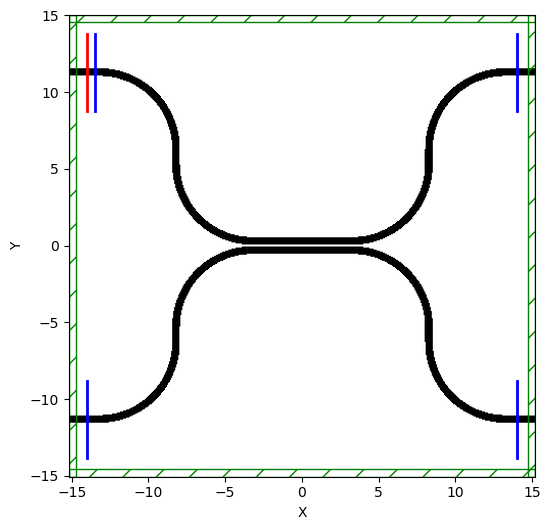

In [19]:
sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(30.4,30.4,0)))

plt.savefig("Plot2D (rank " + str(rank) + ").png", transparent=False, facecolor="white", bbox_inches="tight")

In [20]:
sim.run(until_after_sources=100)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00341797 s
Working in 3D dimensions.
Computational cell is 30.5333 x 30.1333 x 3 with resolution 15
     prism, center = (0,0.3,0)
          height 0.22, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-3.25,0.05,-0.11)
          (-3.25,0.55,-0.11)
          (3.25,0.55,-0.11)
          (3.25,0.05,-0.11)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (0,-0.3,0)
          height 0.22, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-3.25,-0.55,-0.11)
          (-3.25,-0.05,-0.11)
          (3.25,-0.05,-0.11)
          (3.25,-0.55,-0.11)
          dielectric constant epsilon diagonal = (12,12,12)
     prism, center = (-6.41915,2.13085,5.55112e-17)
          height 0.22, axis (0,0,1), sidewall angle: 0 radians, 100 vertices:
          (-8.5,5.3,-0.11)
          (-8,5.3,-0.11)
          (-7.998,5.148,-0.11)
          (-7.99,4.996,-0.11)
          (-7.978,

# mpirun bash

Ao executar esta célula, todo o arquivo será executado na quantidade de cores descrita

Células com "active-ipynb" serão ignoradas

In [5]:
cores = 4
# resultPath = 'ParallelResults/Result.out'

!jupytext --to py meep_ATUALIZADO.ipynb
!mpirun -np $cores python meep_ATUALIZADO.py
# !mpirun -np $cores python MEEPParalleltesting.py > $resultPath

[jupytext] Reading meep_ATUALIZADO.ipynb in format ipynb
[jupytext] Writing meep_ATUALIZADO.py (destination file replaced)
Hi, im proccess 2 and im starting the simulation with monitor p3 only.
Hi, im proccess 3 and im starting the simulation with monitor p4 only.
Hi, im proccess 0 and im starting the simulation with monitor p1 only.
Hi, im proccess 1 and im starting the simulation with monitor p2 only.
/home/caio/Documentos/GitHub/MEEP-Testing/Miniconda3_Files/envs/mp/lib/python3.10/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(
/home/caio/Documentos/GitHub/MEEP-Testing/Miniconda3_Files/envs/mp/lib/python3.10/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(
     prism, center = (0,0.3,0)
          height 0.22, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
      

ValueError: Plane volume must be 2D (a plane).

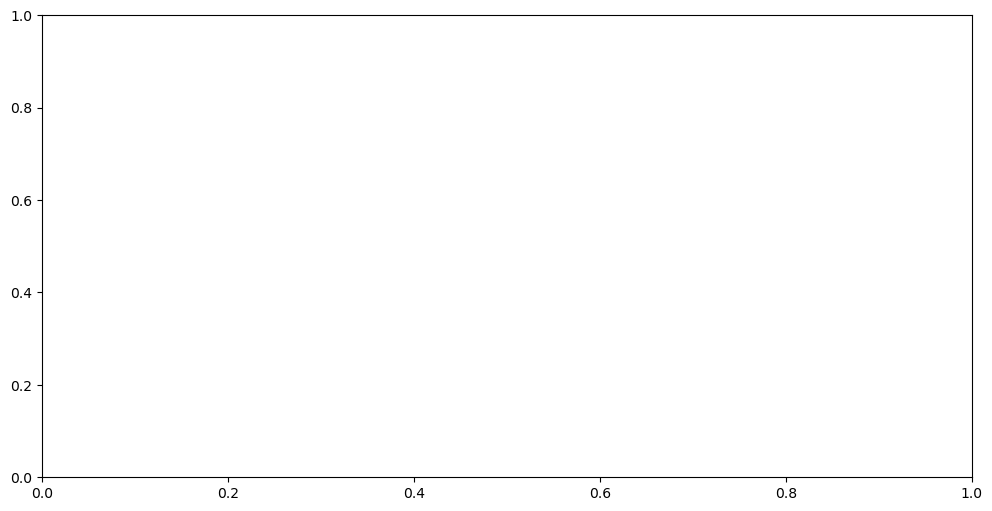

In [6]:
eps_data = sim.get_epsilon()
ez_data = np.real(sim.get_efield_z())

import matplotlib.pyplot as plt

plt.figure()
mp.plot2D(sim,fields=mp.Ez,
           plot_sources_flag=True,
           plot_monitors_flag=True,
           plot_boundaries_flag=True)
plt.axis('off')
plt.show()

plt.savefig("Plot2D Ez (rank " + str(rank) + ").png", transparent=False, facecolor="white", bbox_inches="tight")

In [ ]:
# S parameters
p1_trans = np.zeros(Npontos)
p2_trans = np.zeros(Npontos)
p3_trans = np.zeros(Npontos)
p4_trans = np.zeros(Npontos)

from IPython.utils import io

with io.capture_output() as captured:
    for i in range(Npontos):
        p1_coeff = sim.get_eigenmode_coefficients(mode1, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y+mp.ODD_Z).alpha[0,i,0]
        p1r_coeff = sim.get_eigenmode_coefficients(mode1, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y+mp.ODD_Z).alpha[0,i,1]
        p2_coeff = sim.get_eigenmode_coefficients(mode2, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y+mp.ODD_Z).alpha[0,i,1]
        p3_coeff = sim.get_eigenmode_coefficients(mode3, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y+mp.ODD_Z).alpha[0,i,0]
        p4_coeff = sim.get_eigenmode_coefficients(mode4, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y+mp.ODD_Z).alpha[0,i,0]

        # transmittance
        p1_trans[i] = abs(p1r_coeff)**2/abs(p1_coeff)**2
        p2_trans[i] = abs(p2_coeff)**2/abs(p1_coeff)**2
        p3_trans[i]= abs(p3_coeff)**2/abs(p1_coeff)**2
        p4_trans[i] = abs(p4_coeff)**2/abs(p1_coeff)**2


In [ ]:
w = np.linspace(1520,1575,Npontos)
plt.plot(p3_trans)
plt.plot(p4_trans)
plt.figure()
plt.plot(p1_trans)
plt.plot(p2_trans)

plt.savefig("S parameters (rank " + str(rank) + ").png", transparent=False, facecolor="white", bbox_inches="tight")